In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

sys.path.insert(0, os.path.abspath(os.path.join("..", "src")))
from utils import read_filenames, prepare_datasets

In [36]:
path = '/Users/michal/Documents/studia/sem4/WdUM/Galaxies_Clusterization/data/images'
#path = '/Users/julia/Desktop/semestr-4/ml/projekty/projekt-2/galaxies_data/images_gz2/images'

galaxies = read_filenames(path)
galaxies_train, galaxies_val, galaxies_test = prepare_datasets(galaxies, 100000)

### Loading feature vectors created in processing stage

In [37]:
x_vgg = np.load('../processing/feature_vectors_vgg.npy')
x_simple_conv = np.load('../processing/feature_vectors_simple.npy')

In [38]:
print(f'Shape of x_vgg: {x_vgg.shape}')
print(f'Shape of x_simple_conv: {x_simple_conv.shape}')

Shape of x_vgg: (10000, 227)
Shape of x_simple_conv: (10000, 30)


Scaling data before clustering

In [39]:
scaler = StandardScaler()
x_simple_conv = scaler.fit_transform(x_simple_conv)
x_vgg = scaler.fit_transform(x_vgg)

## Determining the number of clusters for Kmeans

### Within-cluster sum of squares method

In [5]:
def count_wcss_scores(X, k_max):
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

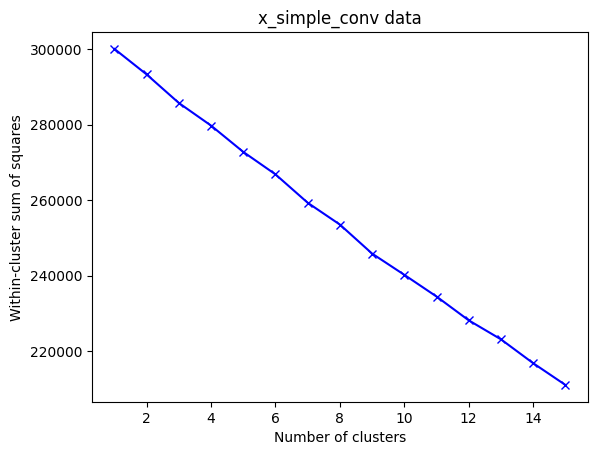

In [40]:
#wcss_vec_vgg = count_wcss_scores(x_vgg, 15)
wcss_vec_simple = count_wcss_scores(x_simple_conv, 15)
x_ticks = list(range(1, len(wcss_vec_simple) + 1))

"""plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(x_ticks, wcss_vec_vgg, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares')
plt.title('x_vgg data')"""

#plt.subplot(1, 2, 2)
plt.plot(x_ticks, wcss_vec_simple, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares')
plt.title('x_simple_conv data')
plt.show()

Not clear what number of clusters to choose. Lets try another method.

### Silhouette method

In [42]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

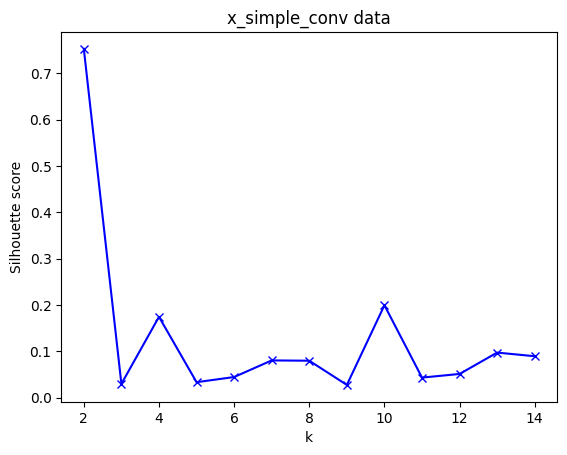

In [43]:
cluster_num_seq = range(2, 15)
#silhouette_vec_vgg = count_clustering_scores(x_vgg, cluster_num_seq, KMeans, silhouette_score)
silhouette_vec_simple = count_clustering_scores(x_simple_conv, cluster_num_seq, KMeans, silhouette_score)

"""plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(cluster_num_seq, silhouette_vec_vgg, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('x_vgg data')"""

#plt.subplot(1, 2, 2)
plt.plot(cluster_num_seq, silhouette_vec_simple, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('x_simple_conv data')
plt.show()

In [7]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(x_simple_conv)

KMeans(n_clusters=4, random_state=42)

In [8]:
groups = {} # cluster_id : images
for file, cluster in zip(galaxies_train[:len(x_simple_conv)], kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [19]:
print([len(groups[i]) for i in range(kmeans.get_params()['n_clusters'])])

[7543, 1053, 79, 1325]


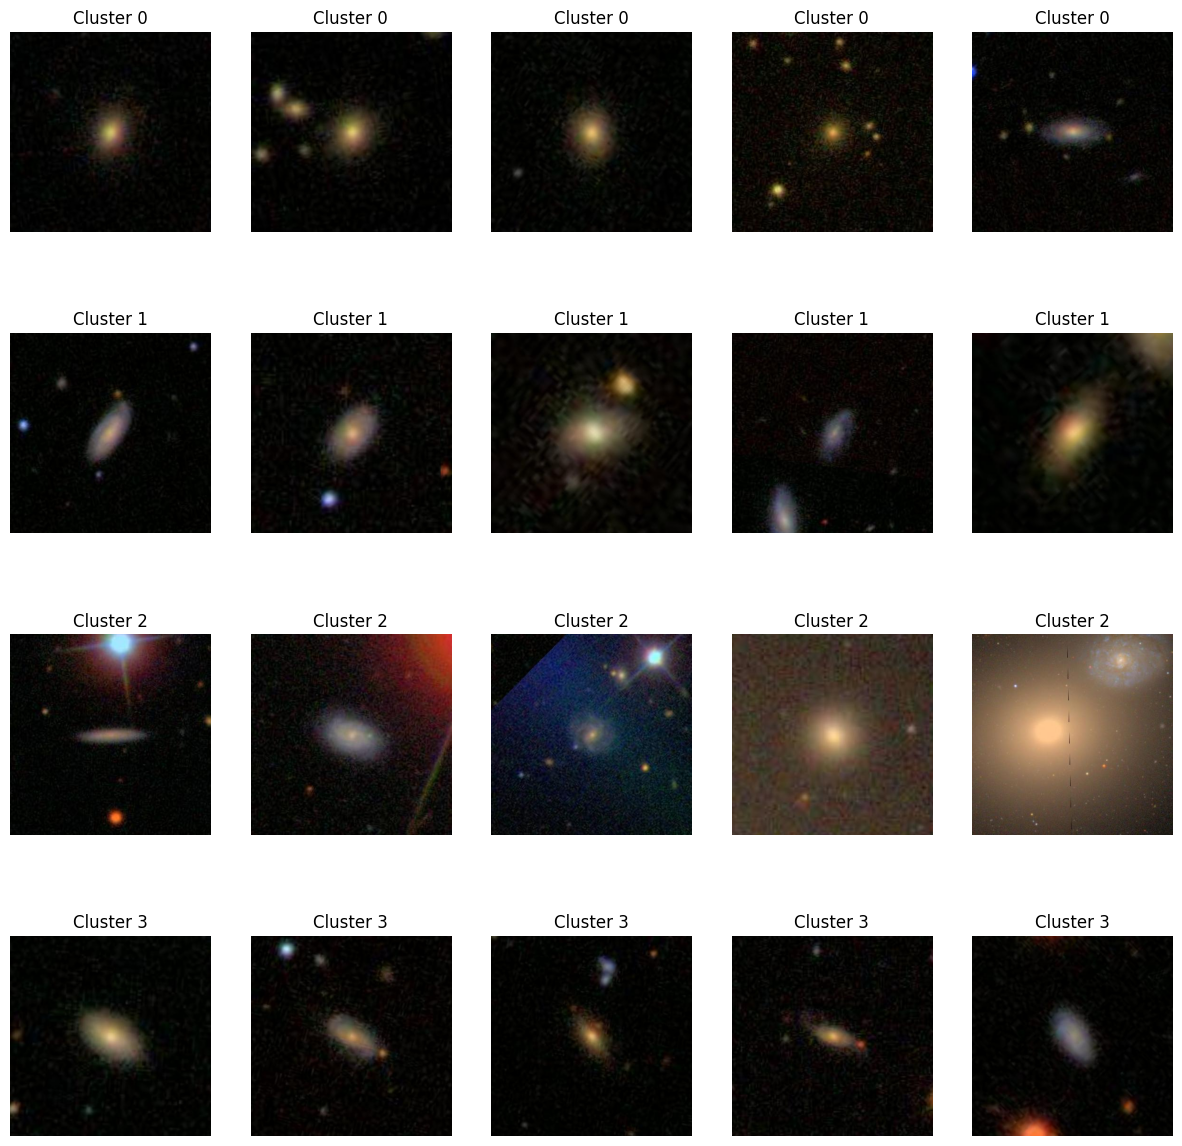

In [23]:
fig, axs = plt.subplots(4, 5, figsize=(15, 15))
for i in range(4):
    for j in range(5):
        ax = axs[i, j]
        ax.axis('off')
        filename = f'../data/images/{groups[i][j]}'
        ax.imshow(plt.imread(filename))
        ax.set_title(f"Cluster {i}")


plt.show()

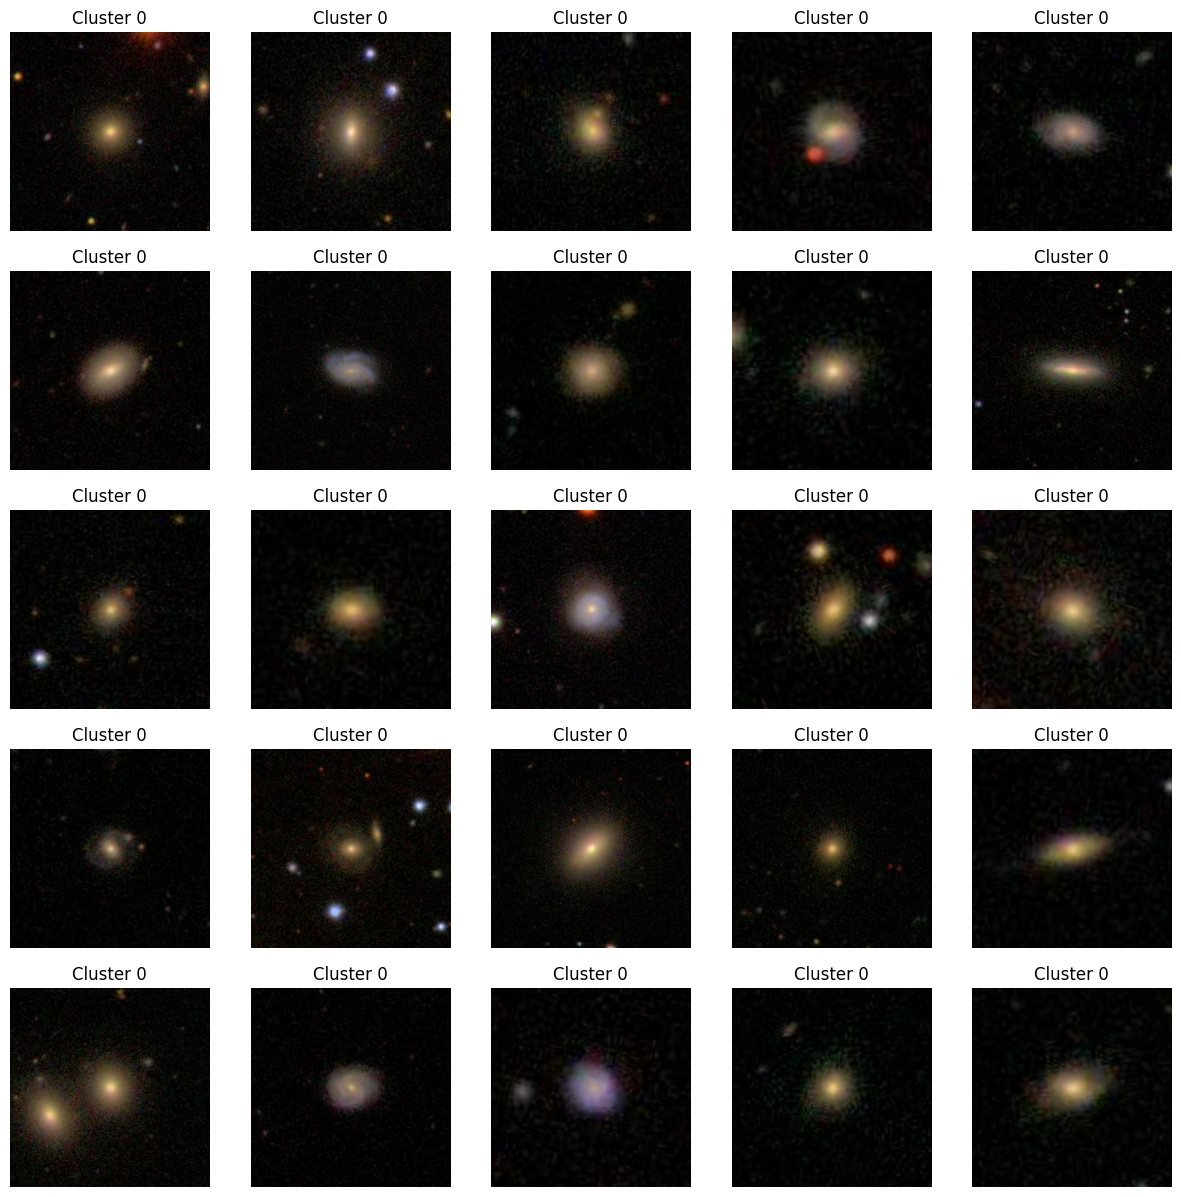

In [25]:
import random

def plot_random_images(cluster, groups, n=25):
    fig, axs = plt.subplots(5, 5, figsize=(15, 15))
    cluster_images = groups[cluster]
    random_images = random.sample(cluster_images, n)
    
    for i in range(5):
        for j in range(5):
            ax = axs[i, j]
            ax.axis('off')
            filename = f'../data/images/{random_images[i*5+j]}'
            ax.imshow(plt.imread(filename))
            ax.set_title(f"Cluster {cluster}")
    
    plt.show()

## DBSCAN

We will set minPts = 2 * dim, where dim is the dimension of our dataset. This is a standard procedure. 

To determine $\epsilon$ we will use a technique that calculates the average distance between each point and its k nearest neighbors, where k = the MinPts. The average k-distances are then plotted in ascending order on a k-distance graph. We choose the optimal value for $\epsilon$ at the point of maximum curvature (i.e. where the graph has the greatest slope).

In [15]:
neighbors = NearestNeighbors(n_neighbors=2 * x_simple_conv.shape[1])
neighbors_fit = neighbors.fit(x_simple_conv)
distances, indices = neighbors_fit.kneighbors(x_simple_conv)

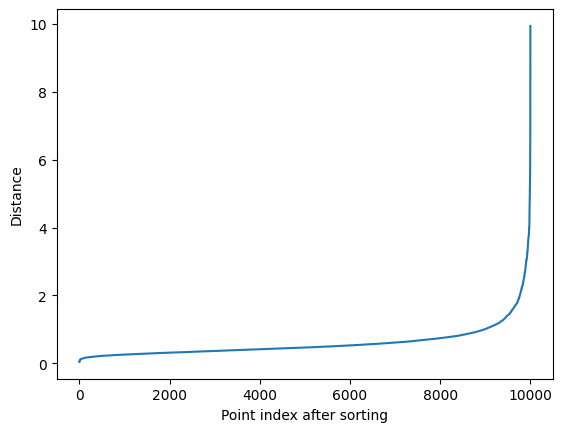

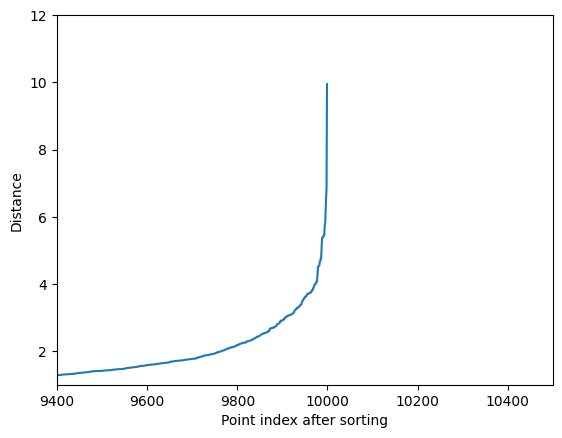

In [16]:
distances = np.sort(distances, axis=0)
plt.plot(distances[:,1])
plt.xlabel('Point index after sorting')
plt.ylabel('Distance')
plt.show()

plt.plot(distances[:,1])
plt.xlabel('Point index after sorting')
plt.ylabel('Distance')
plt.xlim(9400, 10500)
plt.ylim(1, 12)
plt.show()

It looks like optimal value for $\epsilon$ is around 9.

In [19]:
dbscan = DBSCAN(eps=4, min_samples=2*x_simple_conv.shape[1])
dbscan.fit(x_simple_conv)

DBSCAN(eps=4, min_samples=22)

In [20]:
np.unique(dbscan.labels_)

array([-1,  0])